In [1]:
#Spatially explicit metapopulation version of the model

using CSV, DataFrames, Random, LinearAlgebra, Distances, Distributions, SpecialFunctions, Plots


#Calculate the probabilities of getting an offspring with trait k when the gametes with 'trait 
#value' i an j are combined

function qgprob(n::Int64)
    
    #All possible phenotypes
    pheno= collect(1:(2*n+1)) ./ (2*n+1)
    nt=length(pheno)

    G=zeros(Float64,n+1,n+1,n+1)

    for i in 0:n, j in 0:i, k in max(0,(i+j-n)):min(n,(i+j))
                m=collect(0:min(j,k,i+j-k))
                G[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),m).*pdf.(Binomial.(i+j .- (2 .* m)),k .- m))
    end

    for k in 0:n
        G[:,:,1+k]=G[:,:,1+k]+transpose(G[:,:,1+k])
        for i1 in 0:n
            G[i1+1,i1+1,k+1] /= 2
        end
    end

    ind_haplR=zeros(Float64,2*n+1, 2*n+1)

    for k in 0:n
        for i in 0:n
             ind_haplR[1+i,1+k] = G[1+i,1,1+k]
            for j in 0:n
                ind_haplR[1+j+n,1+k]=G[1+n,1+j,1+k]
            end
        end
    end

    R=zeros(Float64,nt,nt,nt)

    for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
         R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                             ind_haplR[1+j,1+q .- (0:q)])
    end
        
    return R
end
    
    
#Function to simulate population dynamics
    
function multipop(Ns::Vector{Float64},r::Vector{Float64},K::Vector{Float64},R::Array{Float64},
                    mmat::Matrix{Float64},pa::Float64,SST::Matrix{Float64})
        
    tsteps=size(SST)[1]
        
    nloci=(size(R)[1]-1)/2
    pheno= collect(1:(2*nloci+1)) ./ (2*nloci+1)
        
    N=rand(Uniform(0,1.0),length(Ns),size(R)[1])
    Ng0= N ./ sum(eachcol(N))
    Np0= Ng0 .* Ns 
    Ngen=deepcopy(Ng0)
    Np=deepcopy(Np0)

    #Set up optimal traits value change with time using SST data
    #Initial value is the population mean (this assumes that the local populations are 
    #already adapted to the local temperature).
        
    topt0= [sum(pheno .* Np[x,:])/sum(Np[x,:]) for x in 1:size(Np)[1]]

    topts=topt0 .+ (1.2 .* SST')
        
    #precalculate selection pressure on phenotypes across time steps
    probsurv=zeros(Float64, tsteps, length(Ns), length(pheno))
        
    [probsurv[x,y,:]=exp.(-((topts[y,x] .-pheno) .^2) ./ 0.16) for x in 1:tsteps, y in 1:length(Ns) ]
     
    #Store results
    res=zeros(Float64,tsteps+1,length(Ns),length(pheno))

    res[1,:,:]=Np0

    for t in 1:tsteps
            
        if sum(floor.(Np))<1
                break
        
        else

            #Selection event
            
            Np=Np .* (probsurv[t,:,:])

            #Reproduction event

            if(pa<1)

                newgen=zeros(Float64,length(Ns),length(pheno))

                for i in 1:size(Ngen)[1]
                    
                    Ngen[i,:]=Np[i,:]/sum(Np[i,:])

                    probs=Ngen[i,:]*(Ngen[i,:]')

                    for j in 1:size(Ngen)[2]

                        newgen[i,j]=sum(probs.*R[:,:,j])
                    end

                    Np[i,:]=((pa*sum(Np[i,:])) .* Ngen[i,:]) + (((1-pa)*sum(Np[i,:])) .* newgen[i,:])  

                end
            end

            #Settlement

            for i in 1:size(Np)[1]
                    
                #Logistic growth to simulate crowding effect during settlement
                Ngen[i,:]=Np[i,:]/sum(Np[i,:])
                                                        
                Np[i,:]=(sum(Np[i,:])+ (r[i]*sum(Np[i,:])*(1-(sum(Np[i,:])/K[i])))) .* Ngen[i,:]

            end

            #Migration
            #add fraction of populations to each other (uniformly across all phenotypes) according to
            #the migration matrix mmat
            for i in 1:size(Np)[1], j in 1:size(Np)[1]

                Np[i,:] += mmat[i,j] .* Np[j,:]
                
            end
            
            Np[Np .<1 ] .= 0
            
            res[t+1,:,:]=Np

        end
    end
    
    return res
        
end


[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Cairo_jll [83423d85-b0ee-5818-9007-b63ccbeb887a]
│   exception = Required dependency Fontconfig_jll [a3f928ae-7b40-5064-980b-68af3947d34b] failed to load from a cache file.
└ @ Base loading.jl:1818
[ Info: Skipping precompilation since __precompile__(false). Importing Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80].
[ Info: Precompiling FFMPEG [c87230d0-a227-11e9-1b43-d7ebe4e7570a]
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Cairo_jll [83423d85-b0ee-5818-9007-b63ccbeb887a]
│   exception = Required dependency Fontconfig_jll [a3f928ae-7b40-5064-980b-68af3947d34b] failed to load from a cache file.
└ @ Base loading.jl:1818
[ Info: Skipping precompilation since __precompile__(false). Importing FFMPEG [c87230d0-a227-11e9-1b43-d7ebe4e7570a].
[ Info: Precompiling FFMPEG_jll [b22a6f82-2f65-5046-a5b2-3

multipop (generic function with 1 method)

In [ ]:
#Set up temperature and ocean current data

#data source: https://podaac.jpl.nasa.gov/dataset/OSCAR_L4_OC_third-deg



In [2]:
R=qgprob(6); 

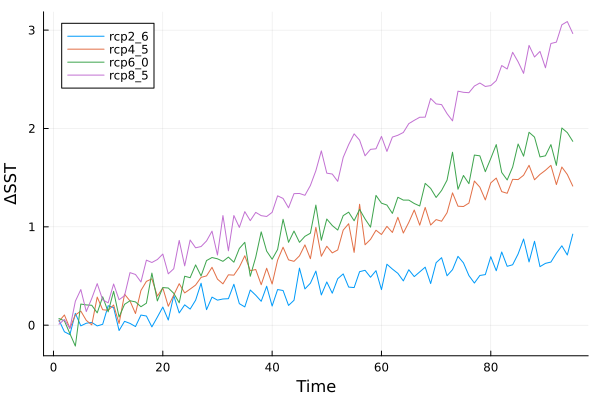

In [3]:
SSTs=DataFrame(rcp2_6=collect(range(start=0,stop=0.775, length=95)),
              rcp4_5=collect(range(start=0,stop=1.6, length=95)),
              rcp6_0=collect(range(start=0,stop=1.925, length=95)),
              rcp8_5=collect(range(start=0,stop=3.0, length=95)))

tsteps=size(SSTs)[1]
       
[ SSTs[:,i] += rand(Normal(0,0.1),size(SSTs)[1]) for i in 1:(size(SSTs)[2]) ]
    
plot(SSTs[:,1], label=names(SSTs)[1],xlabel="Time", ylab=string("ΔSST"))
plot!(SSTs[:,2], label=names(SSTs)[2])
plot!(SSTs[:,3], label=names(SSTs)[3])
plot!(SSTs[:,4], label=names(SSTs)[4])



In [9]:
savefig("SST.png")

"C:\\Users\\mihir\\Documents\\coral_popgen\\codes\\SST.png"

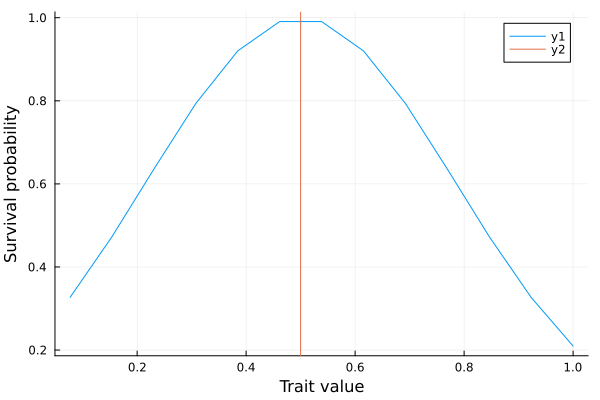

In [4]:
nloci=(size(R)[1]-1)/2
pheno= collect(1:(2*nloci+1)) ./ (2*nloci+1)
survival=exp.(-((0.5 .-pheno) .^2) ./ 0.16)
plot(pheno, survival,xlabel="Trait value",ylabel="Survival probability")
plot!([0.5],seriestype="vline")

In [16]:
Ns::Vector{Float64},r::Vector{Float64},K::Vector{Float64},R::Array{Float64},
                    mmat::Matrix{Float64},pa::Float64,SST::Matrix{Float64}

"C:\\Users\\mihir\\Documents\\coral_popgen\\codes\\fitness.png"

In [11]:
#Model parameters/Function inputs

#Ten populations

popsize=10000.0

popdim=DataFrame(x=(30:(15.0/9):45),y=(30:(20/9):10))

#No. subpopulations - 10 populations spread from north to south
#Ns=[popsize/3,(popsize*2/3) ./repeat([9],9)]
Ns=popsize ./ (repeat([10],10))

#Growth rate
r=repeat([1.38],length(Ns))

#Carrying capacity
K=1.2.*Ns

#Proportion of asexually reproducing individuals
pa=0.0

#Migration parameter
ms=collect(0.0:0.05:0.5)

#Migration matrix NpopsXNpops: Indicates the proportion of the population migrating
#from pop i to pop j
#The matrix can be customised with empirical data
#mmat=[0 m;0 0]

#SST data
SSTs=DataFrame(rcp2_6=collect(range(start=0,stop=0.775, length=95)),
              rcp4_5=collect(range(start=0,stop=1.6, length=95)),
              rcp6_0=collect(range(start=0,stop=1.925, length=95)),
              rcp8_5=collect(range(start=0,stop=3.0, length=95)))

tsteps=size(SSTs)[1]
       
[ SSTs[:,i] += rand(Normal(0,0.1),size(SSTs)[1]) for i in 1:(size(SSTs)[2]) ]
    

#Run the function for the scenario for the mainland-island dynamic:
#One bigger population (bigger K) which ONLY sends individuals (no immigration) 
#to the smaller island (smaller K).


# Params to vary: pa, mmat,SST

SST=Matrix(SSTs[:,[2,1]])

SSTdat=zeros(Float64,5,size(SSTs)[1],2)
for i in 1:5
    SSTdat[i,:,1]=SSTs[:,1]
    SSTdat[i,:,2]=SSTs[:,1] .+ ((i-1)/20)
end

reps=collect(1:5)

#pars=collect(Iterators.product(reps,ms,collect(1:size(SSTdat)[1])))

pars=collect(Iterators.product(reps,ms, collect(1:5)))




5×11×5 Array{Tuple{Int64, Float64, Int64}, 3}:
[:, :, 1] =
 (1, 0.0, 1)  (1, 0.05, 1)  (1, 0.1, 1)  …  (1, 0.45, 1)  (1, 0.5, 1)
 (2, 0.0, 1)  (2, 0.05, 1)  (2, 0.1, 1)     (2, 0.45, 1)  (2, 0.5, 1)
 (3, 0.0, 1)  (3, 0.05, 1)  (3, 0.1, 1)     (3, 0.45, 1)  (3, 0.5, 1)
 (4, 0.0, 1)  (4, 0.05, 1)  (4, 0.1, 1)     (4, 0.45, 1)  (4, 0.5, 1)
 (5, 0.0, 1)  (5, 0.05, 1)  (5, 0.1, 1)     (5, 0.45, 1)  (5, 0.5, 1)

[:, :, 2] =
 (1, 0.0, 2)  (1, 0.05, 2)  (1, 0.1, 2)  …  (1, 0.45, 2)  (1, 0.5, 2)
 (2, 0.0, 2)  (2, 0.05, 2)  (2, 0.1, 2)     (2, 0.45, 2)  (2, 0.5, 2)
 (3, 0.0, 2)  (3, 0.05, 2)  (3, 0.1, 2)     (3, 0.45, 2)  (3, 0.5, 2)
 (4, 0.0, 2)  (4, 0.05, 2)  (4, 0.1, 2)     (4, 0.45, 2)  (4, 0.5, 2)
 (5, 0.0, 2)  (5, 0.05, 2)  (5, 0.1, 2)     (5, 0.45, 2)  (5, 0.5, 2)

[:, :, 3] =
 (1, 0.0, 3)  (1, 0.05, 3)  (1, 0.1, 3)  …  (1, 0.45, 3)  (1, 0.5, 3)
 (2, 0.0, 3)  (2, 0.05, 3)  (2, 0.1, 3)     (2, 0.45, 3)  (2, 0.5, 3)
 (3, 0.0, 3)  (3, 0.05, 3)  (3, 0.1, 3)     (3, 0.45, 3)  (3, 0.5, 3)
 (4, 

95-element Vector{Float64}:
 23.931330855567765
 24.01828438912216
 24.083208774524046
 23.996201464137314
 24.140339909622835
 24.109794961387525
 24.12816106027001
 24.193864981870615
 24.151384252956234
 24.163532425487897
 24.105105561234133
 24.241299459287585
 24.23954513884519
  ⋮
 25.317982596702773
 25.460944447461127
 25.271389802225833
 25.57123106082036
 25.5434200463274
 25.666531313309633
 25.38134562805652
 25.587718183007034
 25.42028236822031
 25.51853653999866
 25.72493951638358
 25.516068893321737

5×95×2 Array{Float64, 3}:
[:, :, 1] =
 0.00251634  -0.0653351  -0.0124603  …  0.634279  0.840631  0.842668
 0.00251634  -0.0653351  -0.0124603     0.634279  0.840631  0.842668
 0.00251634  -0.0653351  -0.0124603     0.634279  0.840631  0.842668
 0.00251634  -0.0653351  -0.0124603     0.634279  0.840631  0.842668
 0.00251634  -0.0653351  -0.0124603     0.634279  0.840631  0.842668

[:, :, 2] =
 0.00251634  -0.0653351  -0.0124603  …  0.634279  0.840631  0.842668
 0.0525163   -0.0153351   0.0375397     0.684279  0.890631  0.892668
 0.102516     0.0346649   0.0875397     0.734279  0.940631  0.942668
 0.152516     0.0846649   0.13754       0.784279  0.990631  0.992668
 0.202516     0.134665    0.18754       0.834279  1.04063   1.04267

In [ ]:
resdat=DataFrame()


for i in 1:length(pars)
    
    mmat=[0 pars[i][2];0 0]

    res=multipop(Ns,r,K,R,mmat,pa,SSTdat[pars[i][3],:,:])
    
    Ndat=[sum(res[x,:,:]) for x in 1:size(res)[1]]

    hl=findfirst(x-> x< (Ndat[1]/2), Ndat)
    
    append!(resdat,DataFrame(reps=pars[i][1],m=pars[i][2],temp_diff=pars[i][3],halflife=hl))
    

end

In [3]:
collect(0.0:0.25:1.0)

5-element Vector{Float64}:
 0.0
 0.25
 0.5
 0.75
 1.0

In [ ]:
CSV.write("coral_res.csv",resdat)

In [3]:
#plot results

resdat=CSV.read("coral_res.csv", DataFrame)

pardat=unique(resdat[:,[:m,:temp_diff]])

resdat1=DataFrame()

for i in 1:size(pardat)[1]
    
    m1=pardat.m[i]
    temp_diff1=pardat.temp_diff[i]
    
    dat1=resdat[resdat.m .== m1 .&& resdat.temp_diff .== temp_diff1,:]
    
    append!(resdat1,DataFrame(m=m1,temp_diff=temp_diff1,
            halflife_m=mean(dat1.halflife),halflife_sd=std(dat1.halflife)))
    
end
    


In [6]:
resdat=resdat1[resdat1.temp_diff .== 1,:]

Row,m,temp_diff,halflife_m,halflife_sd
,Float64,Int64,Float64,Float64
1,0.0,1,3.0,0.0
2,0.05,1,3.0,0.0
3,0.1,1,3.0,0.0
4,0.15,1,3.8,0.447214
5,0.2,1,5.6,0.894427
6,0.25,1,12.0,5.47723
7,0.3,1,16.0,0.0
8,0.35,1,16.0,0.0
9,0.4,1,16.0,0.0


In [7]:
resdat.slim3_m=[3.0,3.0,3.4,4.0,6.0,8.0,9.5,13.2,15.5,20.1,24.0]

11-element Vector{Float64}:
  3.0
  3.0
  3.4
  4.0
  6.0
  8.0
  9.5
 13.2
 15.5
 20.1
 24.0

In [8]:
resdat


Row,m,temp_diff,halflife_m,halflife_sd,slim3_m
,Float64,Int64,Float64,Float64,Float64
1,0.0,1,3.0,0.0,3.0
2,0.05,1,3.0,0.0,3.0
3,0.1,1,3.0,0.0,3.4
4,0.15,1,3.8,0.447214,4.0
5,0.2,1,5.6,0.894427,6.0
6,0.25,1,12.0,5.47723,8.0
7,0.3,1,16.0,0.0,9.5
8,0.35,1,16.0,0.0,13.2
9,0.4,1,16.0,0.0,15.5


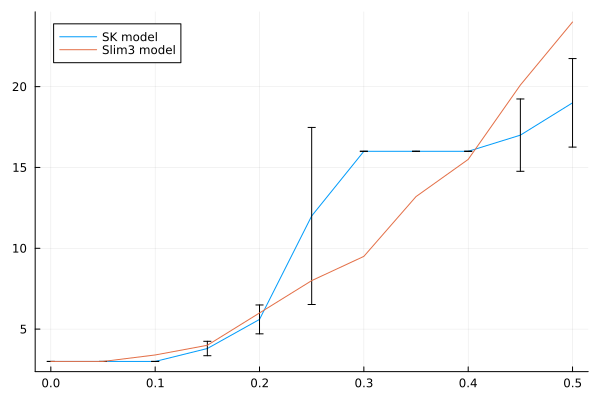

In [13]:
fig4=plot(resdat.m,resdat.halflife_m,yerr=resdat.halflife_sd,label="SK model")
plot!(resdat.m,resdat.slim3_m,label="Slim3 model")

In [15]:
savefig(fig4,"SK_slim3.png")

"C:\\Users\\mihir\\Documents\\coral_popgen\\codes\\SK_slim3.png"

In [ ]:
#Model parameters/Function inputs

#Single population

popsize=1000.0

#No. subpopulations
Ns=[popsize]

#Growth rate
r=[1.38]

#Carrying capacity
K=1.2 .* Ns

#Proportion of asexually reproducing individuals
pa=0

#Migration parameter
ms=collect(0.0:0.1:0.5)

#Migration matrix NpopsXNpops: Indicates the proportion of the population migrating
#from pop i to pop j
#The matrix can be customised with empirical data
#mmat=[0 m;0 0]

#SST data
SSTs=DataFrame(rcp2_6=collect(range(start=0,stop=0.775, length=95)),
              rcp4_5=collect(range(start=0,stop=1.6, length=95)),
              rcp6_0=collect(range(start=0,stop=1.925, length=95)),
              rcp8_5=collect(range(start=0,stop=3.0, length=95)))

tsteps=size(SSTs)[1]
       
[ SSTs[:,i] += rand(Normal(0,0.1),size(SSTs)[1]) for i in 1:(size(SSTs)[2]) ]
    
#plot(SSTs[:,1], label=names(SSTs)[1])
#plot!(SSTs[:,2], label=names(SSTs)[2])
#plot!(SSTs[:,3], label=names(SSTs)[3])
#plot!(SSTs[:,4], label=names(SSTs)[4])

#Run the function for the scenario for the mainland-island dynamic:
#One bigger population (bigger K) which ONLY sends individuals (no immigration) 
#to the smaller island (smaller K).


# Params to vary: pa, mmat

SSTdat=zeros(Float64,5,size(SSTs)[1],2)
for i in 1:5
    SSTdat[i,1,:]=SSTs[:,1]
    SSTdat[i,2,:]=SSTs[:,1] .+ ((i-1)/2)
end

reps=collect(1:10)

pars=collect(Iterators.product(reps,ms))

resdat=DataFrame()

for i in 1:length(pars)
    
    mmat=[0.0 m;0.0 0.0]

    res=multipop(Ns,r,K,R,mmat,pa,SST)
    
    Ndat=[sum(res[x,:,:]) for x in 1:size(res)[1]]

    hl=findfirst(x-> x< (Ndat[1]/2), Ndat)
    
    append!(resdat,DataFrame(reps=pars[i][1],m=pars[i][2],halflife=hl))
    

end

In [13]:
SST

95×2 Matrix{Float64}:
 -0.0686691    0.00251634
  0.0182844   -0.0653351
  0.0832088   -0.0124603
 -0.00379854  -0.0380884
  0.14034      0.130959
  0.109795     0.00264436
  0.128161     0.214372
  0.193865     0.00331384
  0.151384     0.153595
  0.163532     0.154323
  0.105106     0.161203
  0.241299    -0.0819121
  0.239545     0.0171132
  ⋮           
  1.31798      0.862275
  1.46094      0.624919
  1.27139      0.65711
  1.57123      0.62957
  1.54342      0.709322
  1.66653      0.646368
  1.38135      0.750919
  1.58772      0.766185
  1.42028      0.765312
  1.51854      0.634279
  1.72494      0.840631
  1.51607      0.842668